# Laboratorio 4: Aprendizaje Supervisado

> **Análisis de las Posiciones del Aborto en Twitter**
> *Diplomatura en Ciencias de Datos, Aprendizaje Automático y sus aplicaciones.*
> *Integrantes: 
    - Carlos Piaggio
    - Juan Pablo Analian
    

- [Notebook 1](entrega_04_v7.ipynb)
- [Notebook 2](entrega_04_v8.ipynb)

## Parte 3/3 (modelos de RN)    

In [ ]:
#!pip install stop-words #https://pypi.org/project/stop-words/
#!pip install nltk

#import nltk

#nltk.download('stopwords')
#nltk.download('punkt')
#nltk.download('wordnet')

In [1]:
import pandas as pd
import re
from nltk.corpus import stopwords
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report 

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers

Using TensorFlow backend.


## 1. Cargamos dataset que hemos limpiado en la notebook anterior


In [2]:
df_full = pd.read_csv('./out/df_text_junio.csv')

 - quitamos los duplicados

In [3]:
df = df_full.drop_duplicates(subset='text', keep="first")

In [14]:
df.codigo_posicion.value_counts()

1    145147
0     60771
Name: codigo_posicion, dtype: int64

### Metodo auxiliar para graficar

In [22]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

### Largo de cada tweet

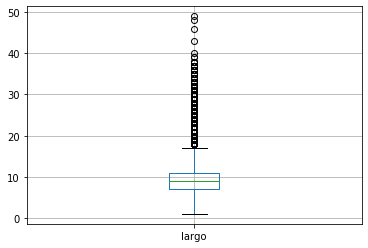

In [12]:
lista = df_full['text'].str.split().str.len()
df_largo = pd.DataFrame({'largo': lista})
df_largo.boxplot(column=['largo'])

In [13]:
df_largo.describe()

,largo
count,1.041164e+06
mean,9.254663e+00
std,3.689159e+00
min,1.000000e+00
25%,7.000000e+00
50%,9.000000e+00
75%,1.100000e+01
max,4.900000e+01


### 4.Embeddings >  Bag of Words
Comenzamos a trabaja el texto de los tweets. 
Tomaremos un largo de 15 elementos por tweet, para contemplar mas del 75% de los tweets que tienen este largo o menos (ver tabla anterior)

In [15]:
# maximo numero de palabras a usar
VOCABULARY_SIZE = 100000

#  tomaremos 15 para  contemplar mas del 75% de los tweets que tienen este largo o menos
MAX_SEQUENCE_LENGTH = 15

tokenizer = Tokenizer(num_words=(VOCABULARY_SIZE))
tokenizer.fit_on_texts(df['text'].values)
#word_index = tokenizer.word_index

print('Se encontraron %s palabras unicas.' % len( tokenizer.word_index))
#cuando aplicamos text_to_sequence, usa solo las 100 mil primeras

Se encontraron 151551 palabras unicas.


### Armamos tensor de entrada para el modelo

In [16]:
X = tokenizer.texts_to_sequences(df['text'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('tamaño del tensor X:', X.shape)

tamaño del tensor X: (205918, 15)


In [17]:
Y = df['codigo_posicion'].values
print('tamaño del tensor Y:', Y.shape)

tamaño del tensor Y: (205918,)


### Separamos datos entre entrenamiento y validacion (80-20)

In [18]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.20, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(164734, 15) (164734,)
(41184, 15) (41184,)


## 2. Red neuronal simple con Keras

In [19]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers

# salida de la 1era capa de embeddings
EMBEDDING_DIM = 10

model = Sequential()
model.add(layers.Embedding(input_dim=VOCABULARY_SIZE + 1, # cantidad maxima de palabras unicas (valores de indinces)
                           output_dim=EMBEDDING_DIM,  #salida, matriz densa.
                           input_length=MAX_SEQUENCE_LENGTH)) #elementos padeados de cada fila del feature = 15 
model.add(layers.Flatten())
model.add(layers.Dense(5, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 15, 10)            1000010   
_________________________________________________________________
flatten (Flatten)            (None, 150)               0         
_________________________________________________________________
dense (Dense)                (None, 5)                 755       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 6         
Total params: 1,000,771
Trainable params: 1,000,771
Non-trainable params: 0
_________________________________________________________________


In [20]:
history = model.fit(X_train, Y_train,
                    epochs=8,
                    verbose=True,
                    validation_data=(X_test, Y_test),
                    batch_size=1000)

loss, accuracy = model.evaluate(X_train, Y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))

loss, accuracy = model.evaluate(X_test, Y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Train on 164734 samples, validate on 41184 samples
Epoch 1/8
164734/164734 [==============================] - 5s 28us/sample - loss: 0.6062 - accuracy: 0.6936 - val_loss: 0.4850 - val_accuracy: 0.7770
Epoch 2/8
164734/164734 [==============================] - 4s 21us/sample - loss: 0.4001 - accuracy: 0.8221 - val_loss: 0.3824 - val_accuracy: 0.8300
Epoch 3/8
164734/164734 [==============================] - 2s 15us/sample - loss: 0.3182 - accuracy: 0.8661 - val_loss: 0.3665 - val_accuracy: 0.8382
Epoch 4/8
164734/164734 [==============================] - 1s 7us/sample - loss: 0.2658 - accuracy: 0.8931 - val_loss: 0.3662 - val_accuracy: 0.8409
Epoch 5/8
164734/164734 [==============================] - 1s 6us/sample - loss: 0.2200 - accuracy: 0.9157 - val_loss: 0.3779 - val_accuracy: 0.8396
Epoch 6/8
164734/164734 [==============================] - 1s 6us/sample - loss: 0.1814 - accuracy: 0.9330 - val_loss: 0.3961 - val_accuracy: 0.8365
Epoch 7/8
164734/164734 [===========================

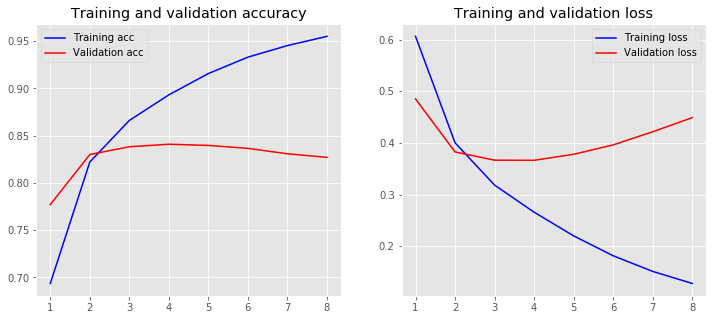

In [23]:
plot_history(history)

## 3 Keras  (dropout + LSTM)

SpatialDropout hace dropout variados.

La capa LSTM puede aprender dependencias largas, (como una "memoria" a largo plazo)

In [24]:
model = Sequential()

model.add(Embedding(input_dim=VOCABULARY_SIZE + 1, # cantidad maxima de palabras unicas (valores de indinces)
                           output_dim=EMBEDDING_DIM,  #salida, matriz densa.
                           input_length=MAX_SEQUENCE_LENGTH)) #elementos padeados de cada fila del feature = 15 
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(5, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 15, 10)            1000010   
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 15, 10)            0         
_________________________________________________________________
lstm (LSTM)                  (None, 100)               44400     
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 505       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 6         
Total params: 1,044,921
Trainable params: 1,044,921
Non-trainable params: 0
_________________________________________________________________
None


In [25]:
history = model.fit(X_train, Y_train,
                    epochs=8,
                    verbose=True,
                    validation_data=(X_test, Y_test),
                    batch_size=1000)

loss, accuracy = model.evaluate(X_train, Y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))

loss, accuracy = model.evaluate(X_test, Y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Train on 164734 samples, validate on 41184 samples
Epoch 1/8
164734/164734 [==============================] - 26s 160us/sample - loss: 0.5079 - accuracy: 0.7540 - val_loss: 0.3928 - val_accuracy: 0.8230
Epoch 2/8
164734/164734 [==============================] - 25s 150us/sample - loss: 0.3590 - accuracy: 0.8446 - val_loss: 0.3712 - val_accuracy: 0.8354
Epoch 3/8
164734/164734 [==============================] - 25s 150us/sample - loss: 0.3144 - accuracy: 0.8691 - val_loss: 0.3711 - val_accuracy: 0.8389
Epoch 4/8
164734/164734 [==============================] - 25s 151us/sample - loss: 0.2814 - accuracy: 0.8859 - val_loss: 0.3766 - val_accuracy: 0.8407
Epoch 5/8
164734/164734 [==============================] - 32s 192us/sample - loss: 0.2577 - accuracy: 0.8975 - val_loss: 0.3839 - val_accuracy: 0.8405
Epoch 6/8
164734/164734 [==============================] - 20s 123us/sample - loss: 0.2386 - accuracy: 0.9065 - val_loss: 0.3964 - val_accuracy: 0.8370
Epoch 7/8
164734/164734 [============

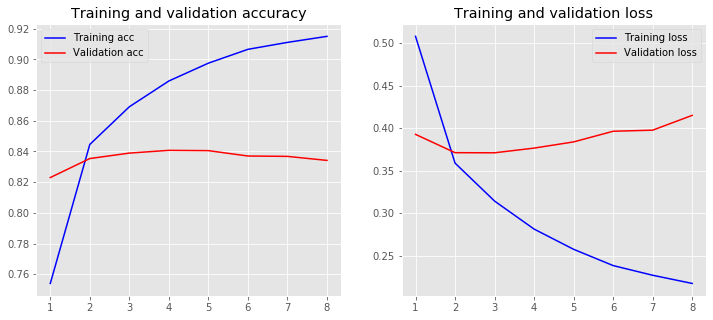

In [26]:
plot_history(history)

## 4. Usando diccionarios pre-entrenados

In [19]:
import numpy as np
#funcion auxiliar
def create_embedding_matrix(filepath, word_index, embedding_dim):
    vocab_size = len(word_index) + 1  # Adding again 1 because of reserved 0 index
    embedding_matrix = np.zeros((vocab_size, embedding_dim))

    with open(filepath) as f:
        for line in f:
            word, *vector = line.split()
            if word in word_index:
                idx = word_index[word] 
                embedding_matrix[idx] = np.array(
                    vector, dtype=np.float32)[:embedding_dim]

    return embedding_matrix

In [20]:
embedding_dim = 300
embedding_matrix = create_embedding_matrix(
     './data/glove-sbwc.i25.vec',
     tokenizer.word_index, embedding_dim)


In [22]:
nonzero_elements = np.count_nonzero(np.count_nonzero(embedding_matrix, axis=1))
nonzero_elements / VOCABULARY_SIZE #How many of the embedding vectors are nonzero

0.49456

> Sólo el 49% de las palabras presentes en el dataset se encuentran en este "corpus". Creemos que no es sufiente el porcentaje para utilizarlo.

## 5 Conclusiones

* Hasta el TP anterior, veníamos trabajando con los datasets agrupando los datos por usuario, para poder predecir si éste  estaba a favor del aborto o en contra.

* Ahora, hemos decidido utilizar el dataset original de los tweets de junio para poder trabajar en este TP. Esto se debe a que de los dos datasets, es el que mas registros tiene y los datos ya estaban etiquetados. 

* Encontramos los datos etiquetados, distribuídos con estos porcentajes: 25% para tweets en contra contra del aborto y 75% de los tweets a favor del aborto. No creemos necesario hacer un undersampling de los datos (o un oversampling).

* En primera instancia, hemos dejado solo el texto del dataset para poder trabajar y luego predecir.

* El objetivo era poder quitar palabras o caracters que no suman valor a la hora de precedir. Principalmente los hashtags que se han utilizado para etiquetar los datos. Si no lo hacíamos, la predicción sería mas simple.

* Ya con el dataset limpio, hemos trabajado con el método Bag of words, utilizando la mecánica TFIDF. Hemos generado un vector de features de 832931 registros x 1500 columnas (train) para el entrenamiento de los mismos modelos utilizados en el TP3. Cabe mencionar que la comparación entre resultados del TP3 con este, no sería correcta porque en el TP anterior teníamos otro dataset, orientado al usuario y no a los tweets.

* Observamos que el mejor clasificador fue el de Regresion Logística con un accuracy sobre el dataset de validación de % 90. representando muy bien a ambas clases. 

* En esta ultima parte, decidimos poner en prueba lo aprendido en la materia de Aprendiza profundo. Es importante contar con gran candidad de datos (como es en este ejemplo donde tenemos mas de 800 mil registros para entrenar).

* En este caso, hemos trabajdo con words embeddings, y utlizando el padding para armar la matriz de entrada de las redes. 

* Primero hemos probado un modelo simple, con keras y vimos que en la 2da iteración hemos alcanzado un accuracy del % 96.5.Muy superior a los otros modelos.

* En segundo lugar, hemos sumado mas complejidad al modelo, adicionando una capa de dropout y otra LSTM (utilizada en RNN). El resultado fu prácticamente similar % 96.5 pero necesitaba mas "epocas" para llegar a este valor.

* Vimos que trabajar con NN en estos casos donde tenemos muchos registros, es una muy buena opción.

